# Описание предметной области.
В университете реализуется on-line тестирование по нескольким дисциплинам. Каждая дисциплина включает некоторое количество вопросов. Ответы на вопрос представлены в виде вариантов ответов, один из этих вариантов правильный.  
  
Студент регистрируется в системе, указав свое имя, фамилию и отчество. После этого он может проходить тестирование по одной или нескольким дисциплинам. Студент имеет несколько попыток для прохождения тестирования  (необходимо сохранять дату попытки). Каждому студенту случайным образом выбирается набор вопросов по дисциплине и формируется индивидуальный тест. Студент отвечает на вопросы, выбирая один из предложенных вариантов ответа.  
  
После окончания тестирования  вычисляется и сохраняется результат (в процентах) попытки.  
  
## Запросы для предметной области:

* Вывести студентов, которые сдавали определенную дисциплину.
* Вывести количество попыток и средний результат по каждой дисциплине.
* Вывести студента (студентов), которые набрали максимальный результат при тестировании.
* Если студент совершал несколько попыток по одной и той же дисциплине, то вывести разницу в днях между первой и последней попыткой.
* Вывести количество студентов, которые проходили тестирование по каждой дисциплине.
* Случайным образом отобрать 3 вопроса по определенной дисциплине.
* Вывести вопросы, на которые отвечал определенный студент в определенной попытке, ответ студента и результат (правильно или нет).
* Посчитать результаты тестирования для всех попыток.
* Для каждого вопроса вывести процент успешных решений и общее количество ответов.
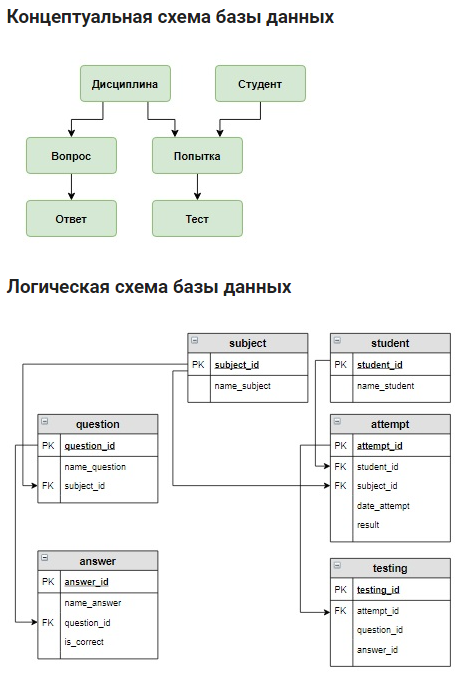

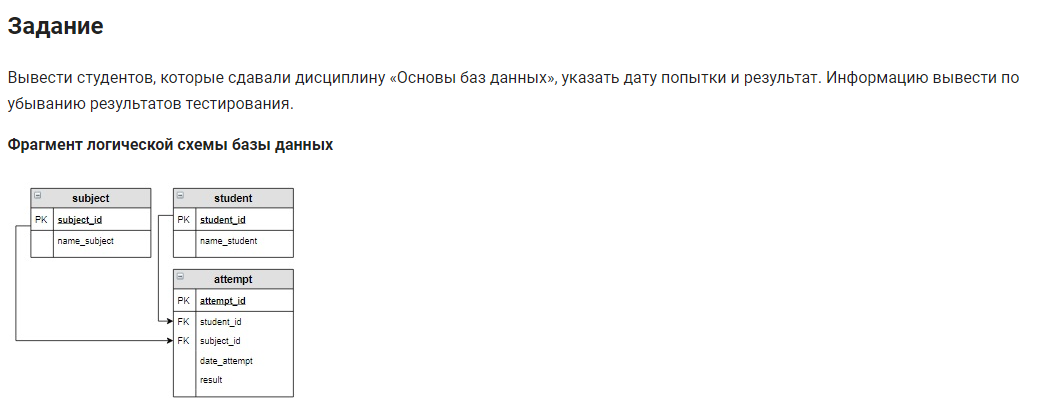

### Для вывода лучших результатов.
~~~~MySQL
WITH best_attempt(student_id, subject_id, best_result) AS (
SELECT student_id, 
       attempt.subject_id,
       MAX(result) AS best_result
  FROM attempt 
 INNER JOIN subject AS s ON s.name_subject = 'Основы баз данных' 
                        AND s.subject_id = attempt.subject_id
 GROUP BY student_id, attempt.subject_id 
)



SELECT student.name_student, 
       attempt.date_attempt,
       attempt.result

  FROM best_attempt AS ba
 INNER JOIN attempt ON (attempt.student_id, attempt.subject_id, attempt.result) = 
                      (ba.student_id, ba.subject_id, ba.best_result)
 INNER JOIN student ON student.student_id = attempt.student_id
 ORDER BY attempt.result DESC;
~~~~
__________

~~~~MySQL
SELECT student.name_student, 
       attempt.date_attempt,
       attempt.result
  FROM attempt 
 INNER JOIN subject AS s ON s.name_subject = 'Основы баз данных' 
                        AND s.subject_id = attempt.subject_id
 INNER JOIN student ON student.student_id = attempt.student_id
 ORDER BY attempt.result DESC;
~~~~

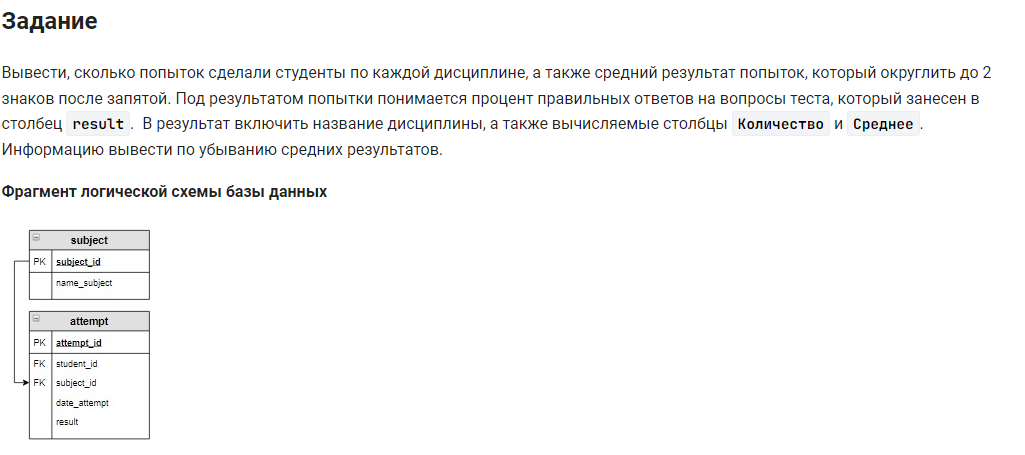

~~~~MySQL
SELECT subject.name_subject,
       COUNT(result) Количество,
       ROUND(AVG(result), 2) Среднее
  FROM attempt
 RIGHT JOIN subject ON subject.subject_id = attempt.subject_id
 GROUP BY attempt.subject_id, subject.name_subject
 ORDER BY Среднее DESC;
~~~~

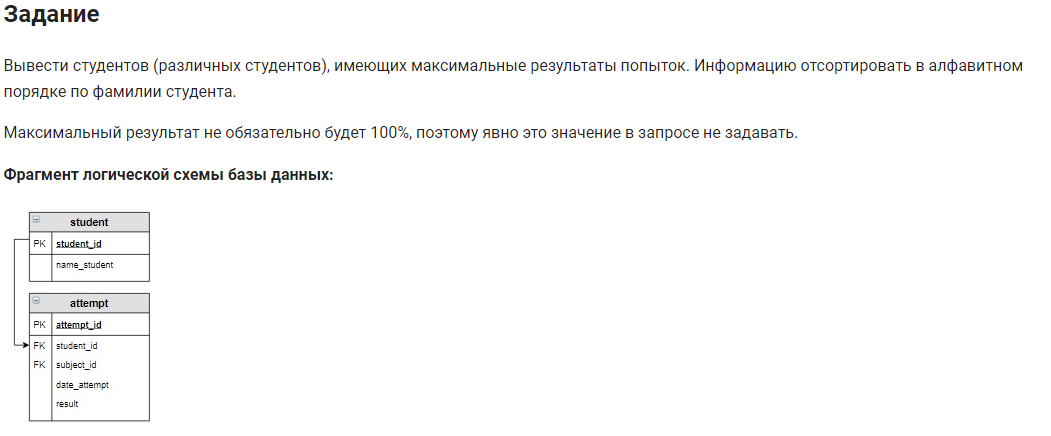

~~~~MySQL
WITH best_res (result) AS (
SELECT result
  FROM attempt
 ORDER BY result DESC
 LIMIT 1
)

SELECT DISTINCT(name_student),
       attempt.result
  FROM attempt 
 INNER JOIN best_res AS br ON br.result = attempt.result
 INNER JOIN student ON student.student_id = attempt.student_id
 ORDER BY name_student;
~~~~

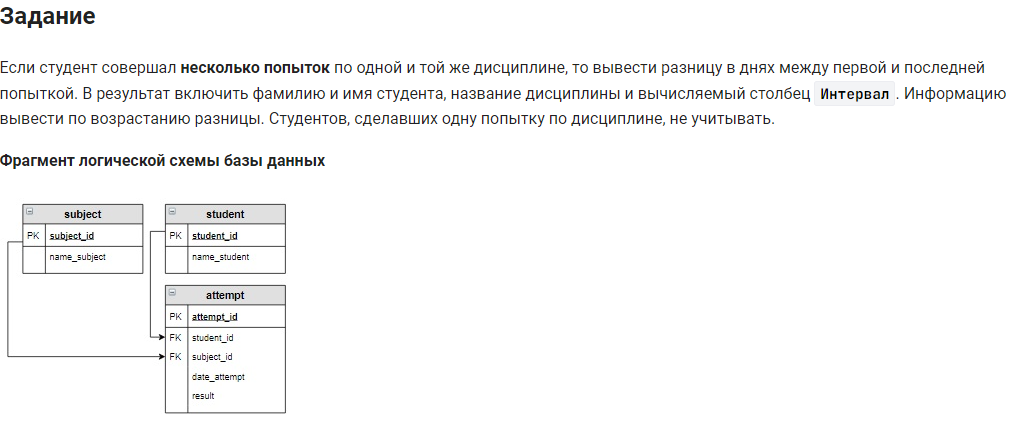

~~~~MySQL
SELECT student.name_student,
       subject.name_subject,
       DATEDIFF(MAX(attempt.date_attempt) , MIN(attempt.date_attempt)) AS Интервал
  FROM attempt 
 INNER JOIN student ON student.student_id = attempt.student_id
 INNER JOIN subject ON subject.subject_id = attempt.subject_id
  
 GROUP BY student.student_id, student.name_student, subject.subject_id, subject.name_subject
HAVING COUNT(attempt.date_attempt) > 1
 ORDER BY Интервал;
~~~~

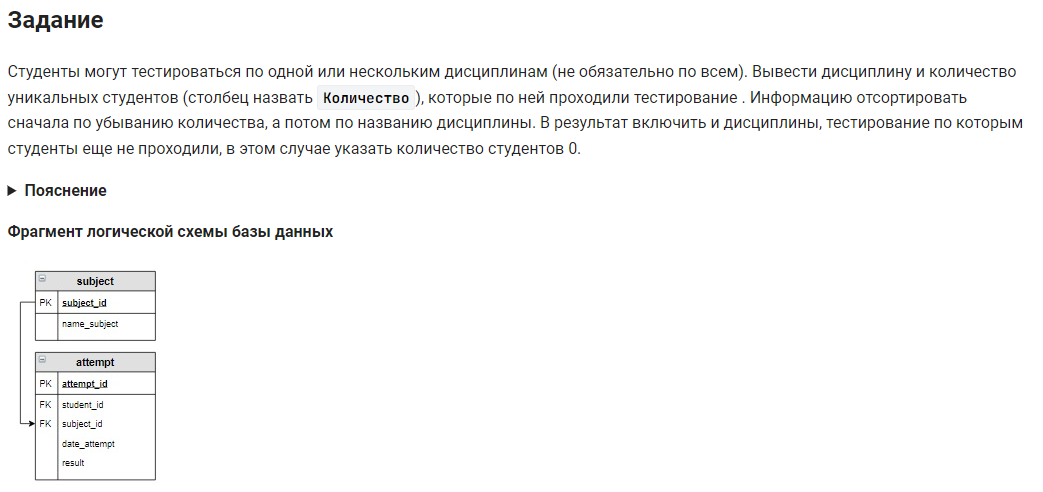

~~~~MySQL
SELECT subject.name_subject,
       COUNT(DISTINCT(attempt.student_id)) AS Количество
  FROM attempt
 RIGHT JOIN subject ON subject.subject_id = attempt.subject_id
 GROUP BY subject.subject_id, subject.name_subject 
 ORDER BY Количество DESC, subject.name_subject;
~~~~

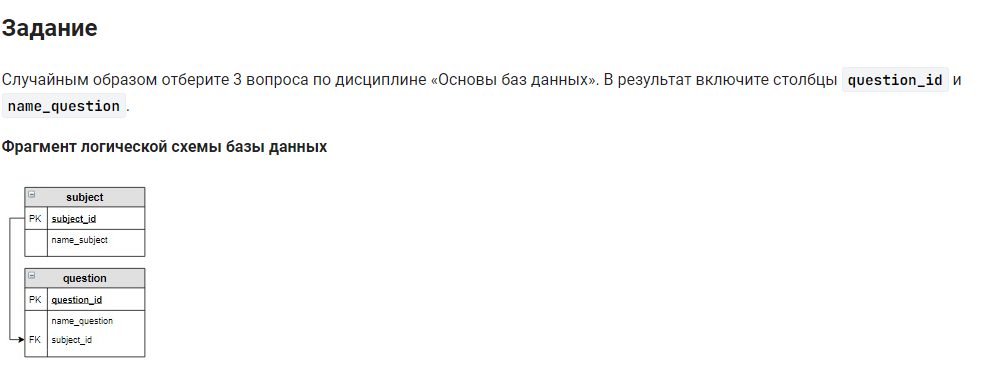

~~~~MySQL
SELECT question_id,
       name_question
  FROM subject
 INNER JOIN question ON subject.name_subject = Основы баз данных
                    AND question.subject_id = subject.subject_id
 ORDER BY RAND()
 LIMIT 3;
~~~~

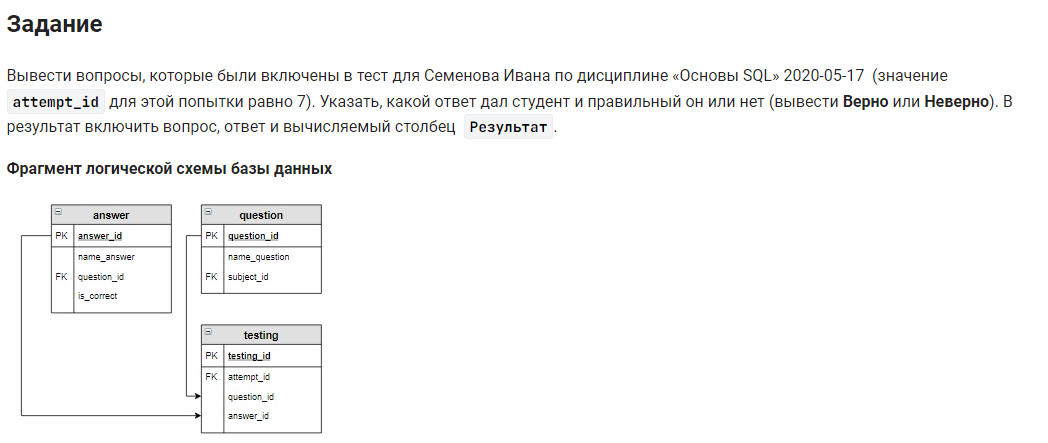

~~~~MySQL
SELECT name_question,
       name_answer,
       IF(is_correct, 'Верно', 'Неверно') AS Результат
  FROM testing
 INNER JOIN question ON testing.attempt_id = 7
                    AND question.question_id = testing.question_id
 INNER JOIN answer ON answer.answer_id = testing.answer_id;
~~~~

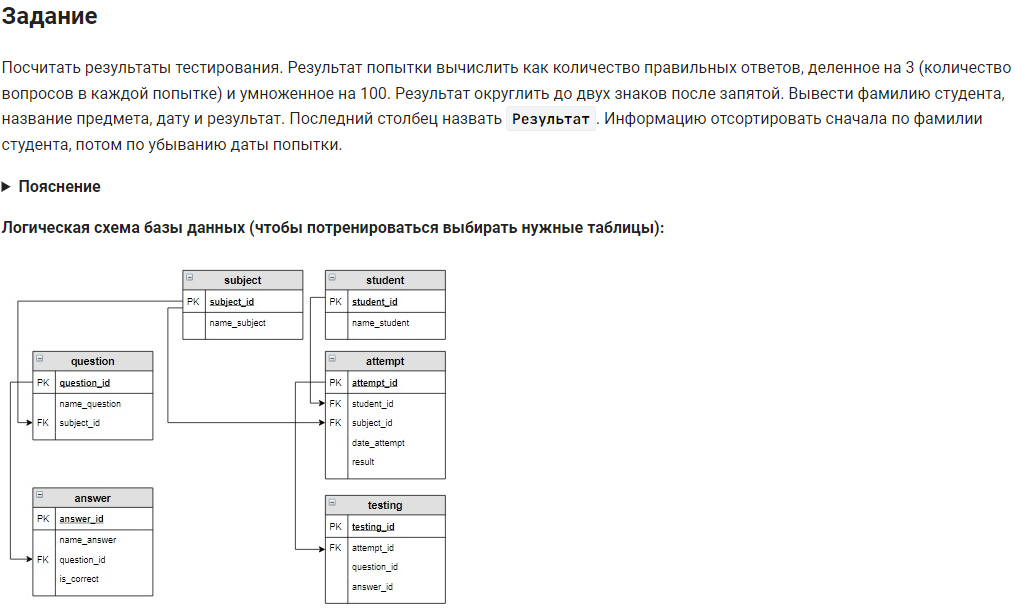

## Этот вариант не принят 
## Вариант ответа, основанный на содержании БД не проходит проверку, система требует именно вычисленное значение для результата. 
~~~~MySQL
SELECT name_student,
       name_subject,
       date_attempt,
       result AS Результат
  FROM attempt 
 INNER JOIN subject ON subject.subject_id = attempt.subject_id
 INNER JOIN student ON student.student_id = attempt.student_id
 ORDER BY name_student, date_attempt DESC;
~~~~

~~~~MySQL
SELECT name_student,
       name_subject,
       date_attempt,
       ROUND((COUNT(is_correct) / 3) * 100, 2) AS Результат
  FROM attempt 
 INNER JOIN subject ON subject.subject_id = attempt.subject_id
 INNER JOIN student ON student.student_id = attempt.student_id
 INNER JOIN testing ON testing.attempt_id = attempt.attempt_id
  LEFT JOIN answer ON answer.is_correct
                  AND answer.answer_id = testing.answer_id
 GROUP BY attempt.student_id, name_student,
       attempt.subject_id, name_subject,
       date_attempt
 ORDER BY name_student, date_attempt DESC;
~~~~

## Возможно будет быстрее работать.
~~~~MySQL
WITH result_stud_subj (subject_id, student_id, date_attempt, result) AS (
SELECT subject_id, 
       student_id,
       date_attempt,
       ROUND((COUNT(is_correct) / 3) * 100, 2) AS result 
  FROM attempt 
 INNER JOIN testing ON testing.attempt_id = attempt.attempt_id
  LEFT JOIN answer ON answer.is_correct
                  AND answer.answer_id = testing.answer_id
 GROUP BY subject_id, 
          student_id,
          date_attempt
)

SELECT name_student,
       name_subject,
       rss.date_attempt,
       rss.result AS Результат
  FROM result_stud_subj AS rss 
 INNER JOIN subject ON subject.subject_id = rss.subject_id
 INNER JOIN student ON student.student_id = rss.student_id
 ORDER BY name_student, date_attempt DESC;
~~~~

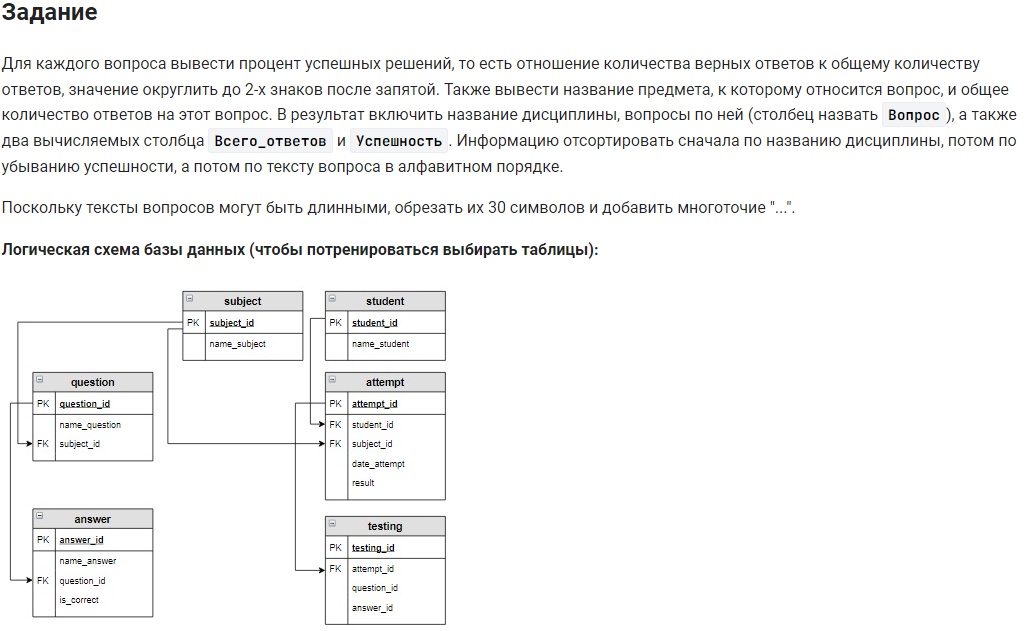

~~~~MySQL
SELECT subject.name_subject,
       CONCAT(SUBSTRING(question.name_question, 1, 30), '...') AS Вопрос,
-- OR       -- CONCAT(LEFT(question.name_question, 30), '...') AS Вопрос,
       COUNT(answer.answer_id) AS Всего_ответов,
       ROUND((SUM(answer.is_correct) / COUNT(answer.answer_id)) * 100 , 2) AS Успешность
  FROM testing 
 INNER JOIN question ON question.question_id = testing.question_id
 INNER JOIN answer ON answer.answer_id = testing.answer_id
 INNER JOIN subject ON subject.subject_id = question.subject_id
 GROUP BY question.question_id
 ORDER BY subject.name_subject,
          Успешность DESC,
          Вопрос;
~~~~

# Далее с помощью запросов корректировки для базы данных «Тестирование» будет реализован процесс подготовки вопросов для тестирования и обработки результатов попытки студента:

* добавление новой попытки для определенного студента и определенной дисциплины;
* формирование тестовых вопросов для этой попытки;
* вычисление результата тестирования;
* удаление неактуальных попыток.

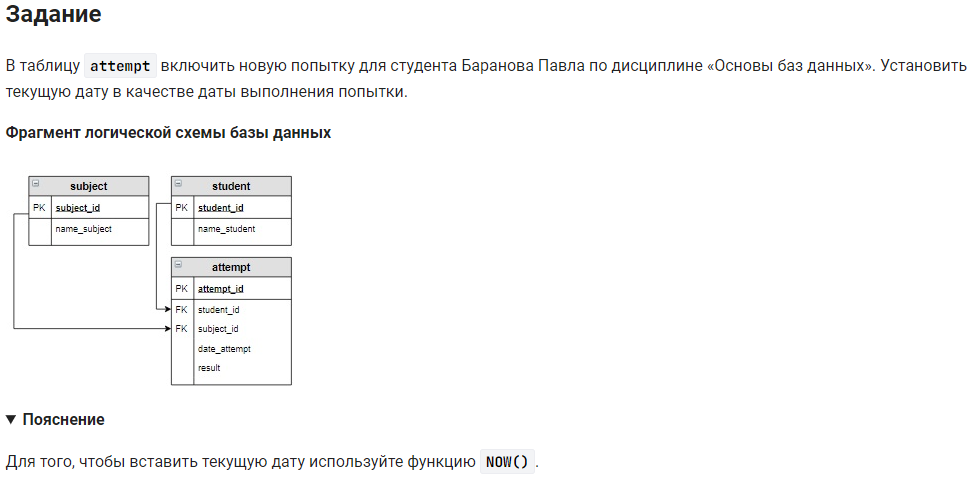

~~~~MySQL
INSERT INTO attempt (student_id,
                     subject_id,
                     date_attempt)
SELECT student_id,
       subject_id,
       NOW()
  FROM student 
 INNER JOIN subject ON name_subject = 'Основы баз данных'
                   AND name_student = 'Баранов Павел';
~~~~

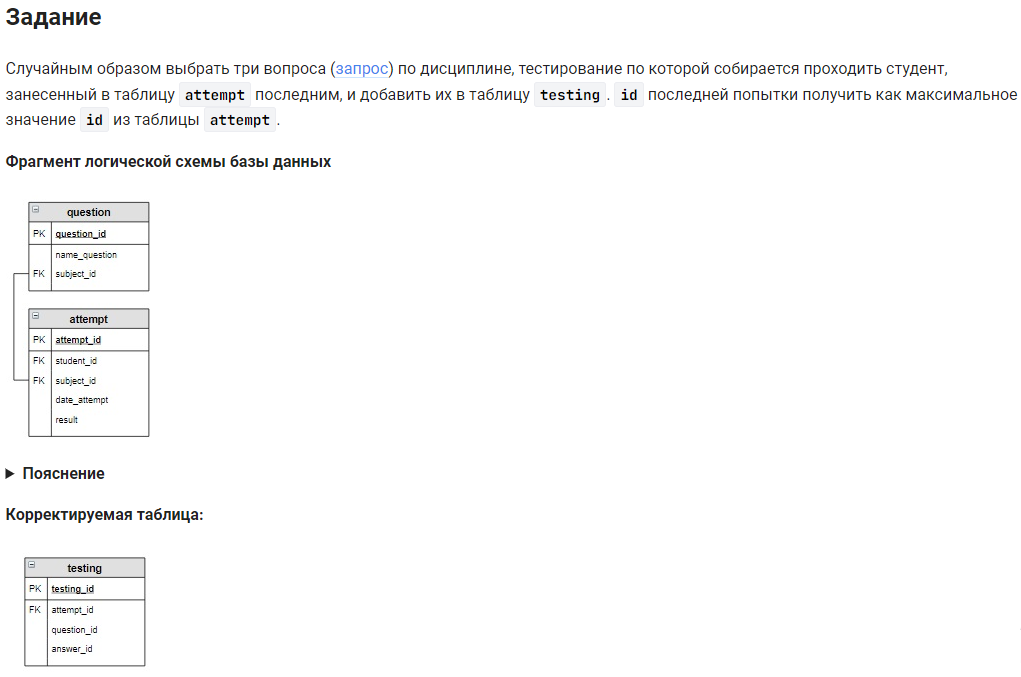

~~~~MySQL
SET @last_attempt_id = (SELECT MAX(attempt_id)
                      FROM attempt);
             
-- OR
/*
SET @last_attempt_id = (SELECT attempt_id
                      FROM attempt
                     ORDER BY attempt_id DESC
                     LIMIT 1);
                     */

INSERT INTO testing (attempt_id,
                     question_id)
SELECT attempt.attempt_id,
       question.question_id
  FROM attempt
 INNER JOIN question ON attempt.attempt_id = @last_attempt_id
                    AND question.subject_id = attempt.subject_id
 ORDER BY RAND()                   
 LIMIT 3;    
~~~~

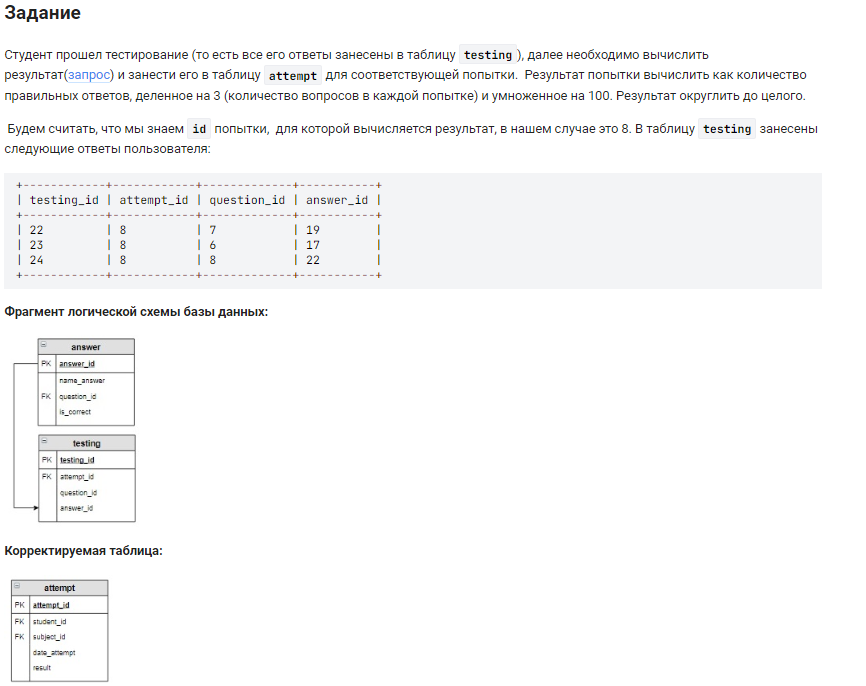

~~~~MySQL
UPDATE attempt 
   SET result = (SELECT ROUND((SUM(answer.is_correct) / 3) * 100)
                   FROM testing
                  INNER JOIN answer ON testing.attempt_id = 8
                                   AND answer.answer_id = testing.answer_id)
 WHERE attempt_id = 8;
~~~~

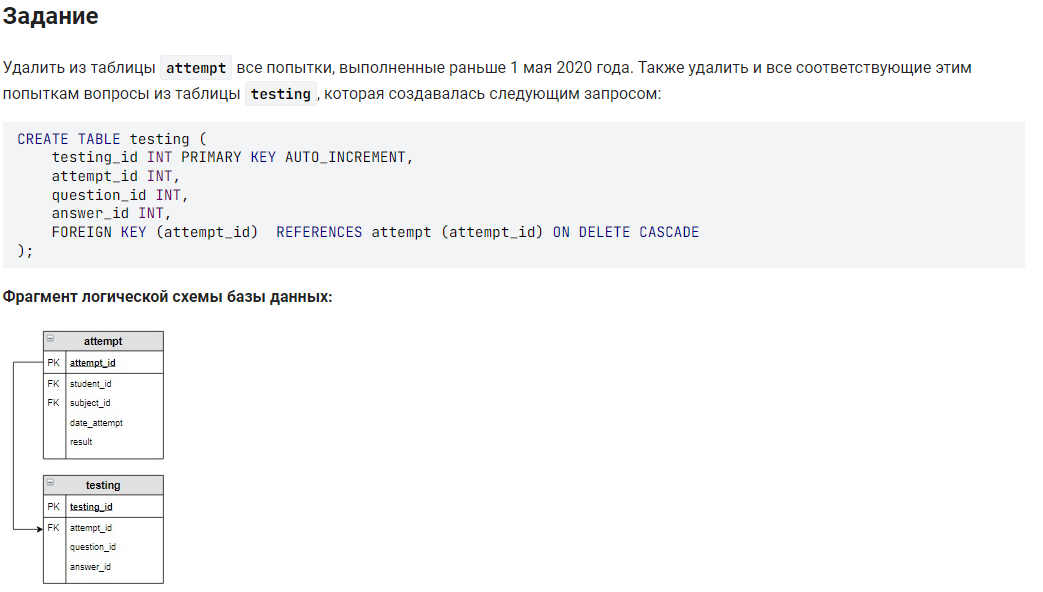

~~~~MySQL
DELETE FROM attempt
      WHERE DATEDIFF(date_attempt, DATE('2020.05.01')) < 0;
~~~~

# Предметная область
Университет состоит из совокупности факультетов (школ). Поступление абитуриентов осуществляется на образовательные программы по результатам Единого государственного экзамена (ЕГЭ). Каждая образовательная программа относится к определенному факультету, для нее определены необходимые для поступления предметы ЕГЭ, минимальный балл по этим предметам, а также план набора (количество мест) на образовательную программу.

В приемную комиссию абитуриенты подают заявления на образовательную программу, каждый абитуриент может выбрать несколько образовательных программ (но не более трех). В заявлении указывается фамилия, имя, отчество абитуриента, а также его достижения: получил ли он медаль за обучение в школе, имеет ли значок ГТО и пр. При этом за каждое достижение определен дополнительный балл. Абитуриент предоставляет сертификат с результатами сдачи  ЕГЭ. Если абитуриент выбирает образовательную программу, то у него обязательно должны быть сданы предметы, определенные на эту программу, причем балл должен быть не меньше минимального по данному предмету.

Зачисление абитуриентов осуществляется так: сначала вычисляется сумма баллов по предметам на каждую образовательную программу, добавляются баллы достижения, затем абитуриенты сортируются в порядке убывания суммы баллов и отбираются первые по количеству мест, определенному планом набора.

## Запросы для предметной области:

* Вывести абитуриентов, которые хотят поступать на определенную образовательную программу.
* Вывести образовательные программы, на которые для поступления необходим определенный предмет ЕГЭ.
* Вывести статистическую информацию по каждому предмету  ЕГЭ.
* Вывести образовательные программы, минимальные баллы по каждому предмету которых, превышают заданное значение.
* Вывести образовательные программы. которые имеют самый большой план набора.
* Посчитать, сколько дополнительных баллов получит каждый абитуриент.
* Посчитать конкурс на каждую образовательную программу.
* Вывести образовательные программы, на которые для поступления необходимы два определенных предмета ЕГЭ.
* Посчитать количество баллов каждого абитуриента на каждую образовательную программу по результатам ЕГЭ.
* Вывести абитуриентов, которые не могут быть зачислены на образовательную программу.

### Концептуальная схема базы данных
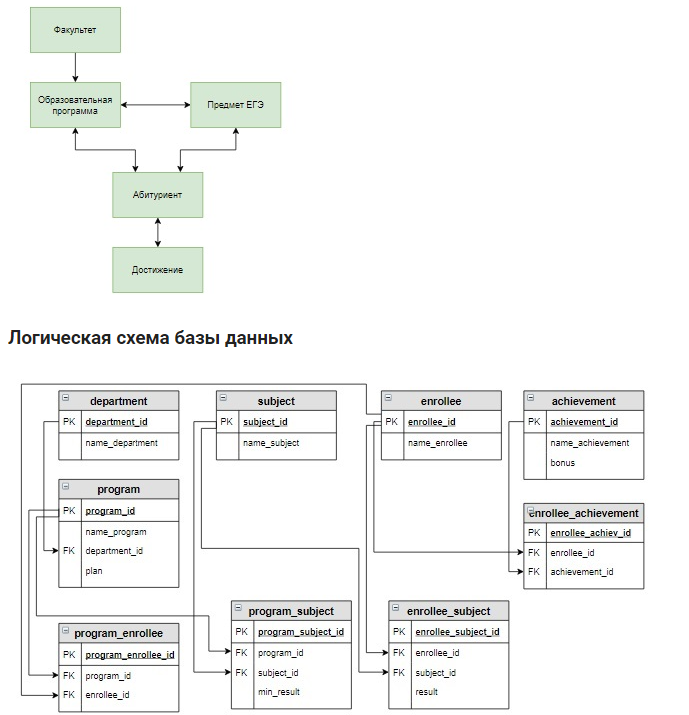

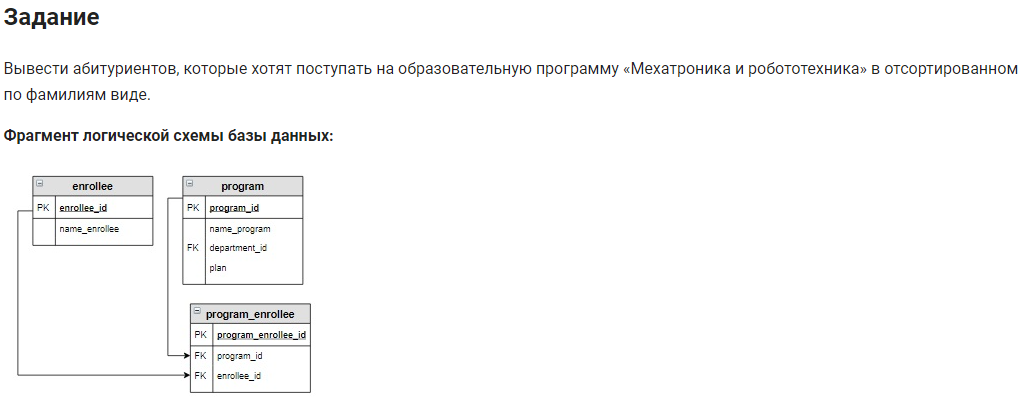

~~~~MySQL
SELECT enrollee.name_enrollee
  FROM program_enrollee AS pe 
 INNER JOIN program ON program.name_program = 'Мехатроника и робототехника'
                   AND program.program_id = pe.program_id
 INNER JOIN enrollee ON enrollee.enrollee_id = pe.enrollee_id
 ORDER BY enrollee.name_enrollee;
~~~~

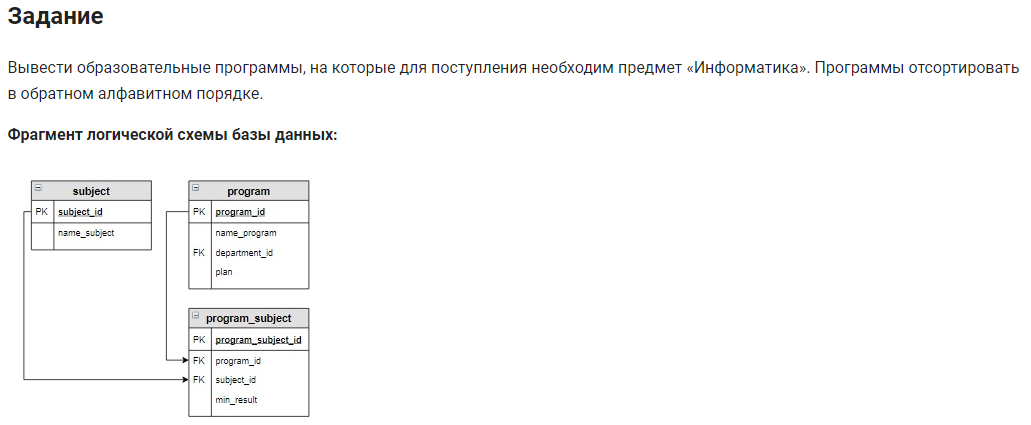

~~~~MySQL
SELECT program.name_program
  FROM program_subject AS ps
 INNER JOIN subject ON subject.name_subject = 'Информатика'
                   AND subject.subject_id = ps.subject_id
 INNER JOIN program ON program.program_id = ps.program_id
 ORDER BY program.name_program DESC;
~~~~

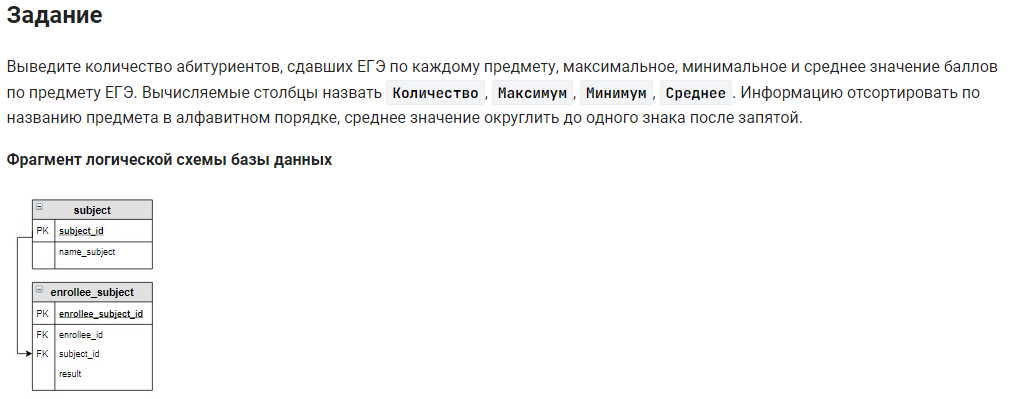

~~~~MySQL
WITH subject_metrics (subject_id,
                      Количество,
                      Максимум,
                      Минимум,
                      Среднее
                     ) AS (
    SELECT subject_id,
           COUNT(enrollee_id),
           MAX(result),
           MIN(result),
           ROUND(AVG(result), 1)
      FROM enrollee_subject AS es
     GROUP BY subject_id )
 
SELECT subject.name_subject,
       sm.Количество,
       sm.Максимум,
       sm.Минимум,
       sm.Среднее
  FROM subject_metrics AS sm
 INNER JOIN subject ON subject.subject_id = sm.subject_id
 ORDER BY subject.name_subject;
~~~~

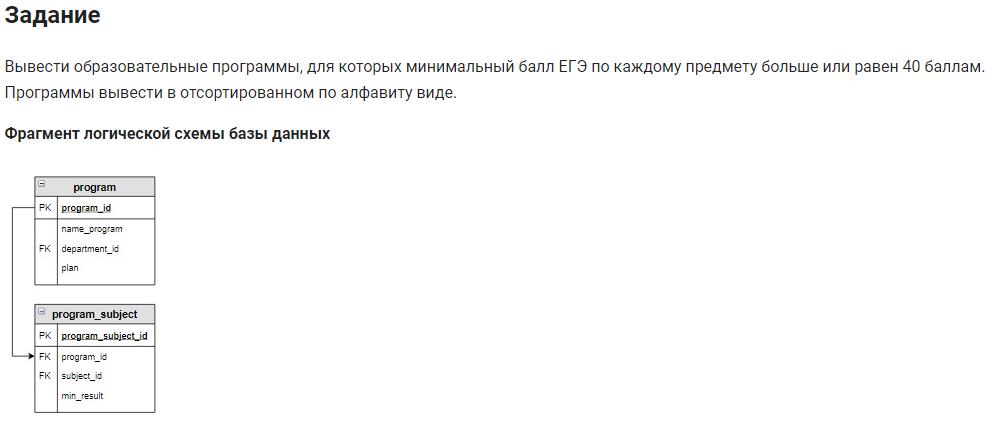

~~~~MySQL
WITH program_min (program_id) AS (
SELECT program_id
  FROM program_subject 
 GROUP BY program_id
HAVING MIN(min_result) >= 40)

SELECT name_program
  FROM program
 INNER JOIN program_min AS pm ON pm.program_id = program.program_id
 ORDER BY program.name_program;
~~~~

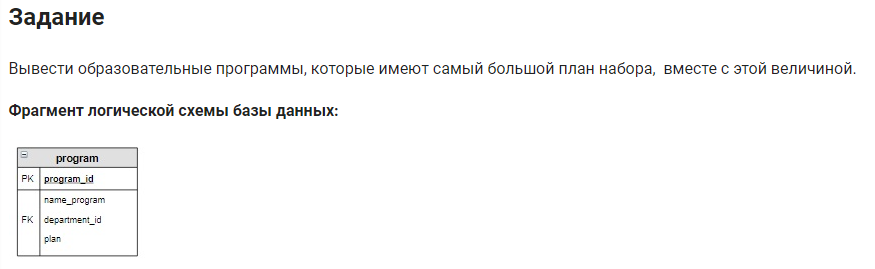

## Не прошел проверку 
~~~~MySQL
SET @max_plan = (SELECT MAX(plan)
                   FROM program);

SELECT name_program,
       plan
  FROM program
 WHERE plan = @max_plan;
~~~~
![image.png](attachment:image.png)

## Решение через использование подзапросов
~~~~MySQL
SELECT name_program,
       plan
  FROM program
 WHERE plan = (SELECT MAX(plan)
                   FROM program);
~~~~

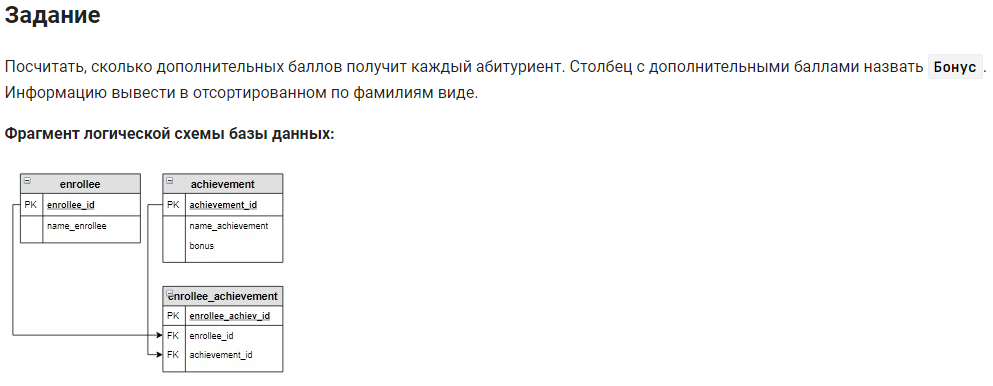

~~~~MySQL
WITH sum_bonus (enrollee_id, Бонус) AS (
SELECT e_a.enrollee_id,
       SUM(achievement.bonus)
  FROM enrollee_achievement AS e_a
 LEFT JOIN achievement ON achievement.achievement_id = e_a.achievement_id
 GROUP BY e_a.enrollee_id)
 
SELECT enrollee.name_enrollee,
       IF(sb.Бонус IS NULL, 0, sb.Бонус) AS Бонус
  FROM sum_bonus AS sb
 RIGHT JOIN enrollee ON enrollee.enrollee_id = sb.enrollee_id
 ORDER BY enrollee.name_enrollee;
~~~~

~~~~MySQL
SELECT enrollee.name_enrollee,
       IF(SUM(achievement.bonus) IS NULL, 0, SUM(achievement.bonus)) AS Бонус
  FROM enrollee
  LEFT JOIN enrollee_achievement AS e_a ON enrollee.enrollee_id = e_a.enrollee_id
  LEFT JOIN achievement ON achievement.achievement_id = e_a.achievement_id
  GROUP BY enrollee.enrollee_id
  ORDER BY enrollee.name_enrollee;
~~~~

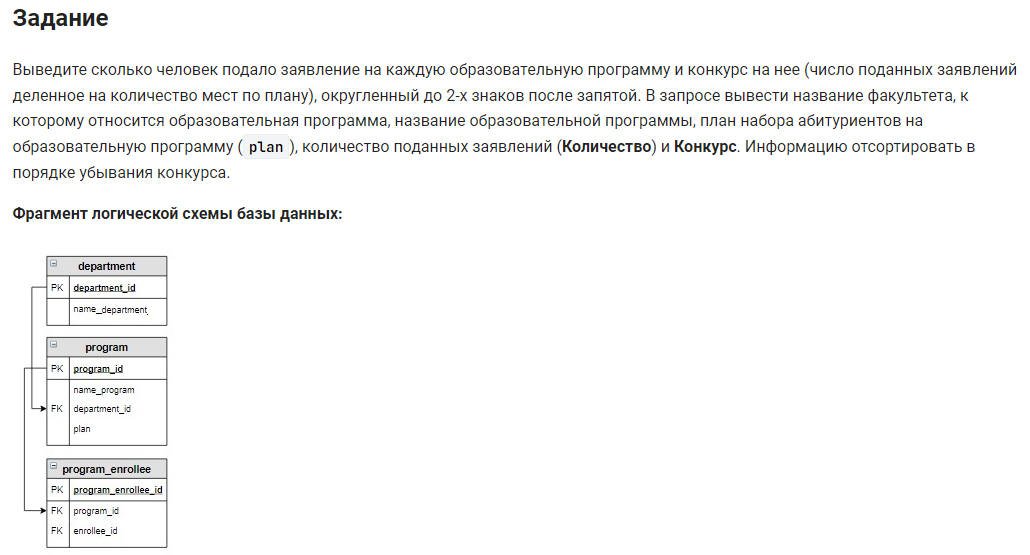

~~~~MySQL
WITH sum_enrollee (program_id, sum_empl) AS (
     SELECT program_id,
            COUNT(enrollee_id) 
       FROM program_enrollee AS pe 
      GROUP BY program_id
)

SELECT department.name_department,
       program.name_program,
       program.plan,
       IF(se.sum_empl IS NULL, 0, se.sum_empl)  AS Количество, 
       ROUND(IF(se.sum_empl IS NULL, 0, se.sum_empl) / program.plan, 2) AS Конкурс
  FROM program
 INNER JOIN department ON department.department_id = program.department_id
  LEFT JOIN sum_enrollee AS se ON se.program_id = program.program_id
 ORDER BY Конкурс DESC;
~~~~

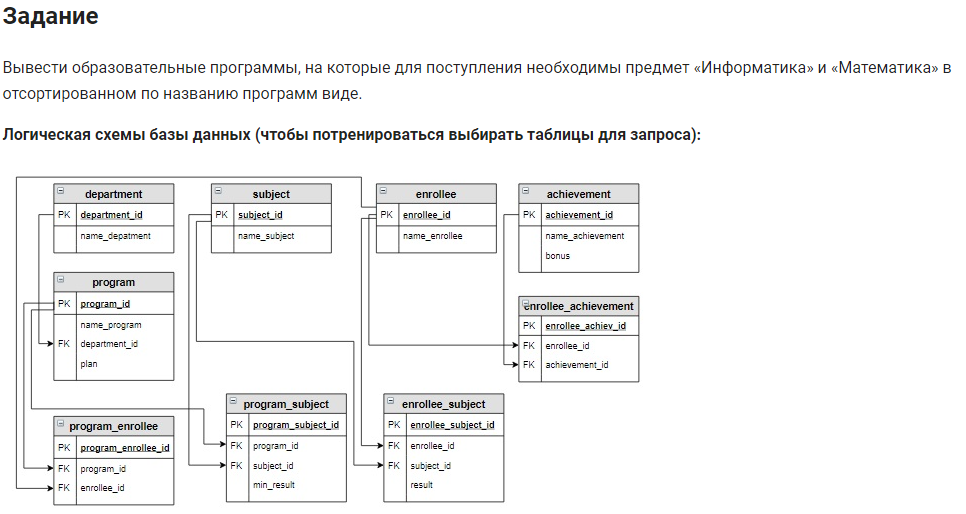

~~~~MySQL
SELECT program.name_program
  FROM program_subject AS ps
 INNER JOIN subject ON subject.name_subject IN ('Информатика', 'Математика')
                   AND subject.subject_id = ps.subject_id
 INNER JOIN program ON program.program_id = ps.program_id
 GROUP BY program.program_id
HAVING COUNT(subject.subject_id) = 2
 ORDER BY program.name_program;                
~~~~

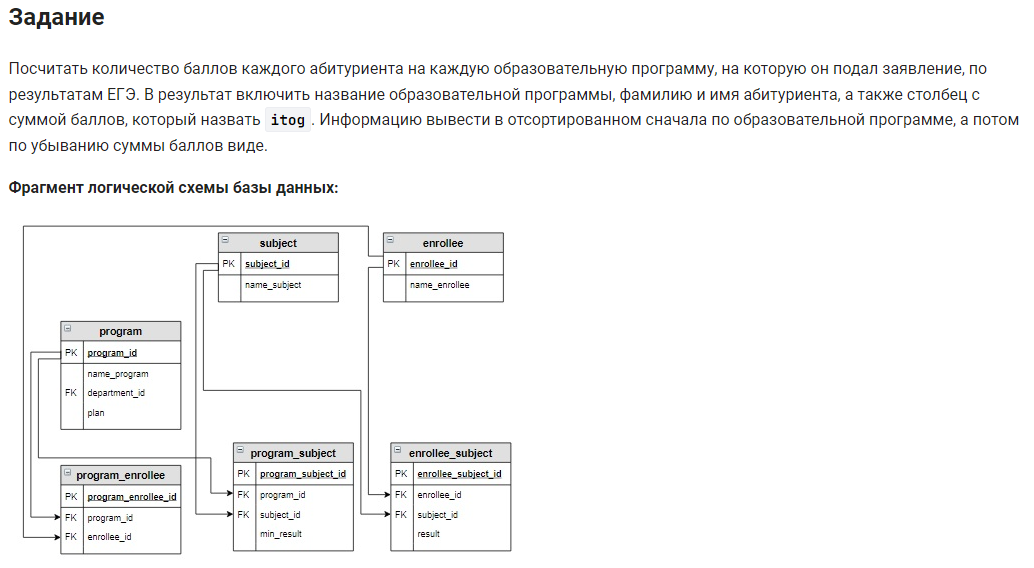

~~~~MySQL
SELECT program.name_program,
       enrollee.name_enrollee,
       SUM(es.result) as itog
  FROM program_enrollee AS pe
 INNER JOIN program ON program.program_id = pe.program_id
 RIGHT JOIN program_subject AS ps ON ps.program_id = program.program_id
  LEFT JOIN enrollee ON enrollee.enrollee_id = pe.enrollee_id
 INNER JOIN enrollee_subject AS es ON es.enrollee_id = pe.enrollee_id
                                  AND es.subject_id = ps.subject_id
 GROUP BY program.program_id, program.name_program, enrollee.enrollee_id, enrollee.name_enrollee
 ORDER BY program.name_program, itog DESC;                                  
  
-- Разный порядок и вид JOIN
 
SELECT program.name_program,
       enrollee.name_enrollee,
       SUM(es.result) as itog
  FROM program
  INNER JOIN program_subject AS ps ON ps.program_id = program.program_id
 RIGHT JOIN program_enrollee AS pe ON pe.program_id = program.program_id
  LEFT JOIN enrollee_subject AS es ON es.enrollee_id = pe.enrollee_id
                                  AND es.subject_id = ps.subject_id
  RIGHT JOIN enrollee ON enrollee.enrollee_id = es.enrollee_id
 GROUP BY program.program_id, program.name_program, enrollee.enrollee_id, enrollee.name_enrollee
 ORDER BY program.name_program, itog DESC 
 
 --
SELECT program.name_program,
       enrollee.name_enrollee,
       SUM(result) as itog
  FROM program
 INNER JOIN program_subject AS ps ON ps.program_id = program.program_id
 INNER JOIN program_enrollee AS pe ON pe.program_id = program.program_id
 INNER JOIN enrollee_subject AS es ON es.enrollee_id = pe.enrollee_id
                                  AND es.subject_id = ps.subject_id
 INNER JOIN enrollee ON enrollee.enrollee_id = es.enrollee_id
 GROUP BY enrollee.enrollee_id, program.program_id
 ORDER BY program.name_program, itog DESC;
~~~~

## Задание
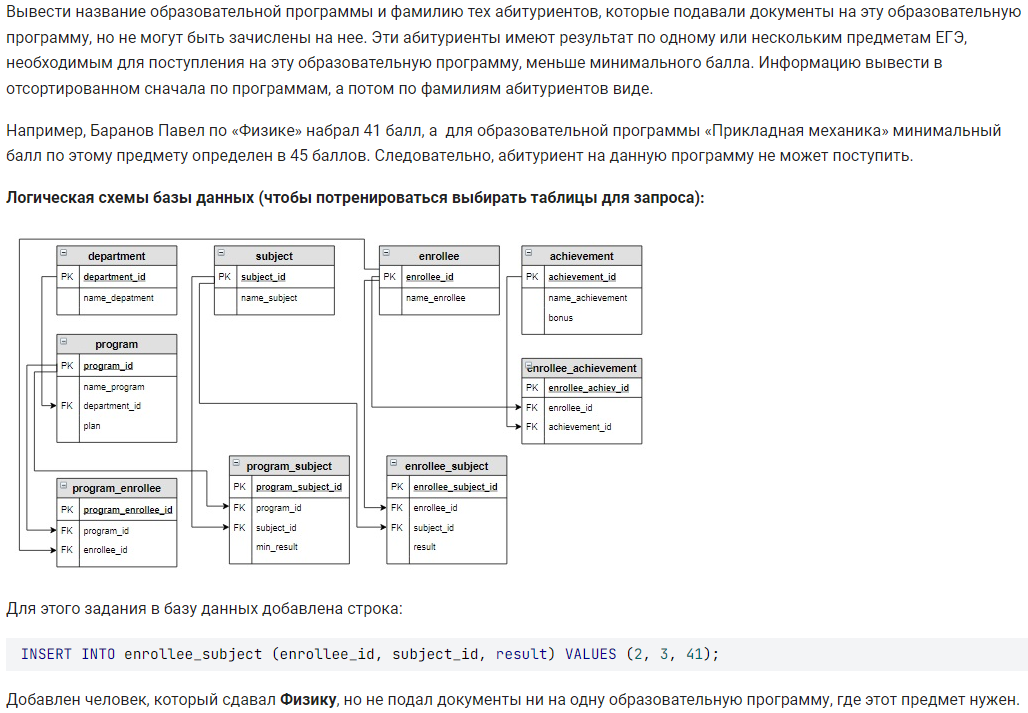

~~~~MySQL
SELECT program.name_program,
       enrollee.name_enrollee
  FROM program_enrollee AS pe
 INNER JOIN program ON program.program_id = pe.program_id
 INNER JOIN program_subject AS ps ON ps.program_id = program.program_id
 RIGHT JOIN enrollee_subject AS es ON es.subject_id = ps.subject_id
                                  AND es.result < ps.min_result
                                  AND es.enrollee_id = pe.enrollee_id
 INNER JOIN enrollee ON enrollee.enrollee_id = pe.enrollee_id
 GROUP BY program.program_id, enrollee.enrollee_id
 ORDER BY program.name_program,
          enrollee.name_enrollee;
~~~~

## Далее с помощью запросов корректировки данных для базы данных «Абитуриент» формируется список абитуриентов, рекомендованных к зачислению в университет:

* создается таблица с суммой баллов абитуриентов по предметам ЕГЭ в соответствии с поданными заявлениями;
* из таблицы удаляются абитуриенты, если они не набрали минимального балла по предмету, необходимому для поступления на образовательную программу;
* абитуриентам, у которых есть медаль или значок ГТО, добавляются дополнительные баллы;
* абитуриенты сортируются в соответствии с набранными баллами по каждой образовательной программе;
* формируется список абитуриентов, рекомендованных к зачислению ( вставляется столбец для нумерации, осуществляется нумерация студентов по образовательной программе, выбираются абитуриенты с наибольшими баллами в соответствии с планом набора).

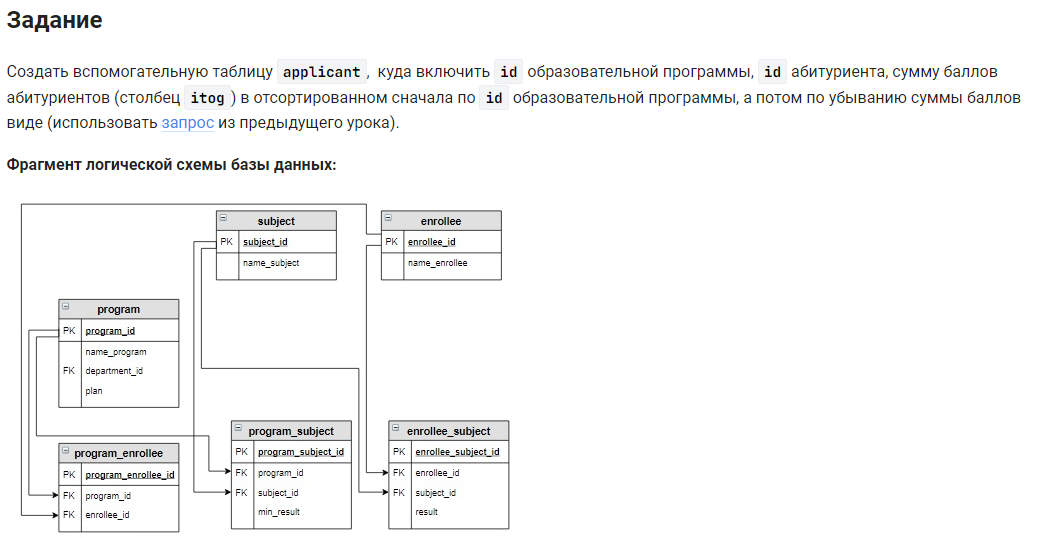

~~~~MySQL
CREATE TABLE applicant AS
    SELECT ps.program_id,
           pe.enrollee_id,
           SUM(es.result) as itog
      FROM program_subject AS ps
     INNER JOIN program_enrollee AS pe ON pe.program_id = ps.program_id
     INNER JOIN enrollee_subject AS es ON es.enrollee_id = pe.enrollee_id
                                      AND es.subject_id = ps.subject_id
     GROUP BY es.enrollee_id, ps.program_id
     ORDER BY ps.program_id, itog DESC;
~~~~

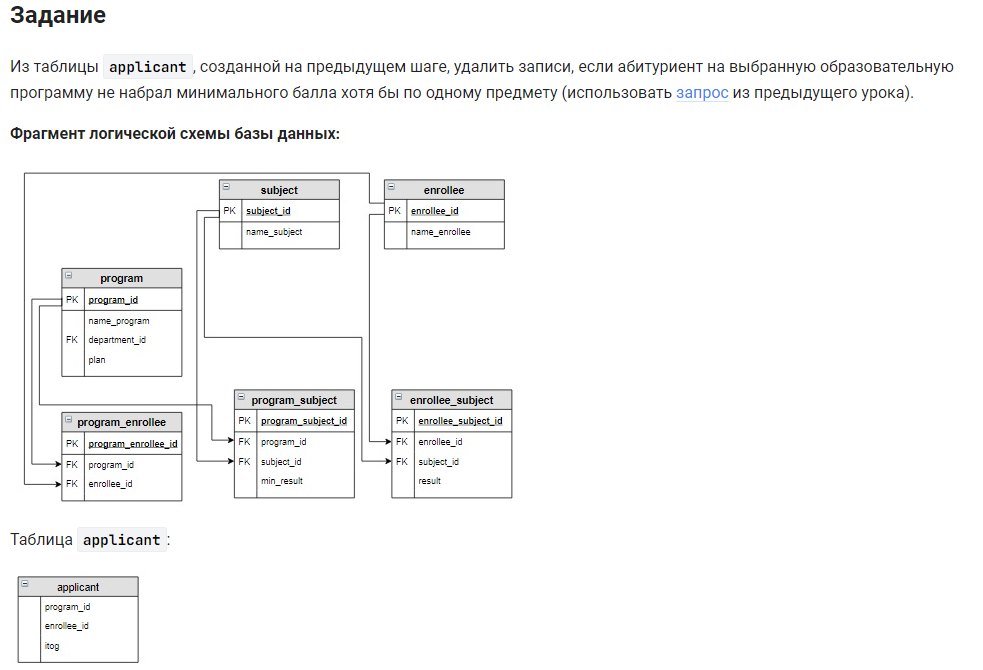

~~~~MySQL
DELETE FROM applicant 
 USING applicant
 INNER JOIN program_subject AS ps ON ps.program_id = applicant.program_id
 RIGHT JOIN enrollee_subject AS es ON es.enrollee_id = applicant.enrollee_id 
                                  AND es.subject_id = ps.subject_id
                                  AND es.result < ps.min_result
WHERE es.enrollee_id;
~~~~

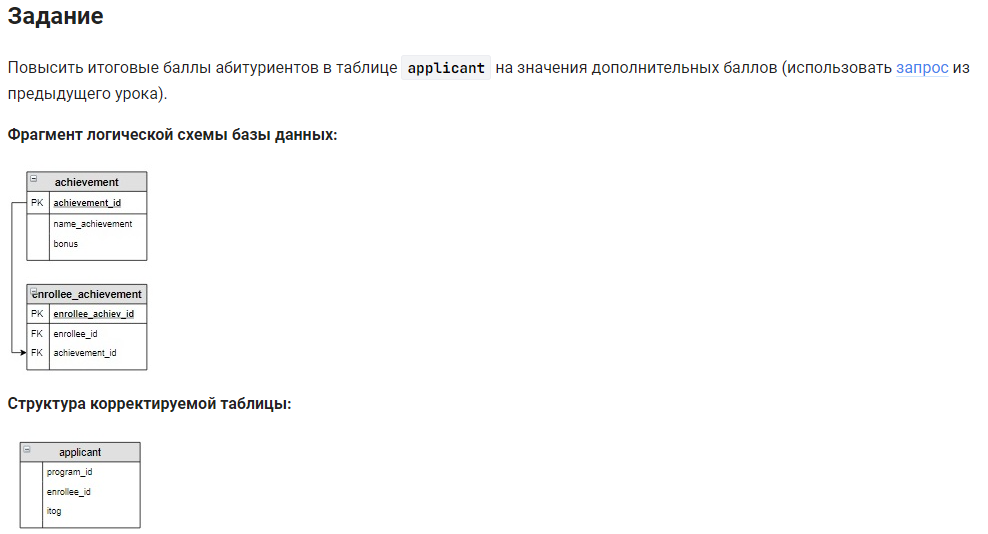

~~~~MySQL
WITH dop_point_enrollee (enrollee_id, dop_point) AS (
     SELECT enrollee_id, 
            SUM(achievement.bonus)
       FROM enrollee_achievement AS e_a
      INNER JOIN achievement ON achievement.achievement_id = e_a.achievement_id
      GROUP BY enrollee_id
)

UPDATE applicant
 RIGHT JOIN dop_point_enrollee AS dpe ON dpe.enrollee_id = applicant.enrollee_id
   SET applicant.itog = applicant.itog +  dpe.dop_point
 WHERE dpe.enrollee_id;
~~~~

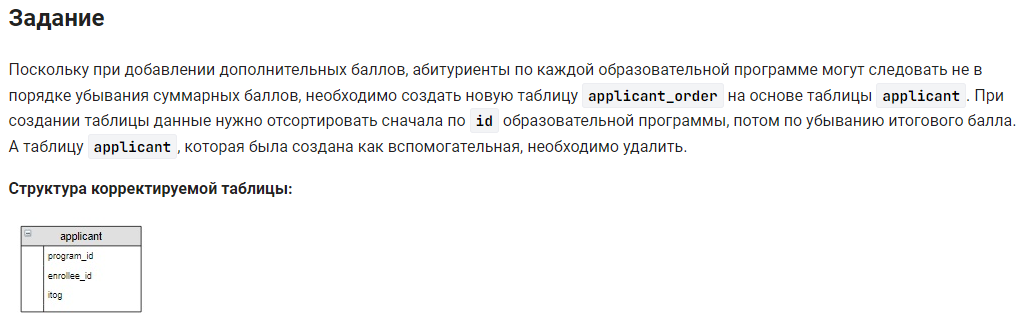

~~~~MySQL
CREATE TABLE applicant_order AS 
      SELECT *
        FROM applicant
       ORDER BY program_id, itog DESC;
DROP TABLE applicant; 
~~~~

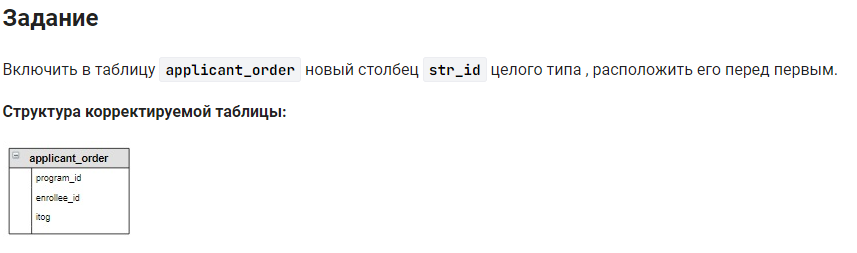

~~~~MySQL
ALTER TABLE applicant_order 
        ADD str_id INT FIRST;
~~~~

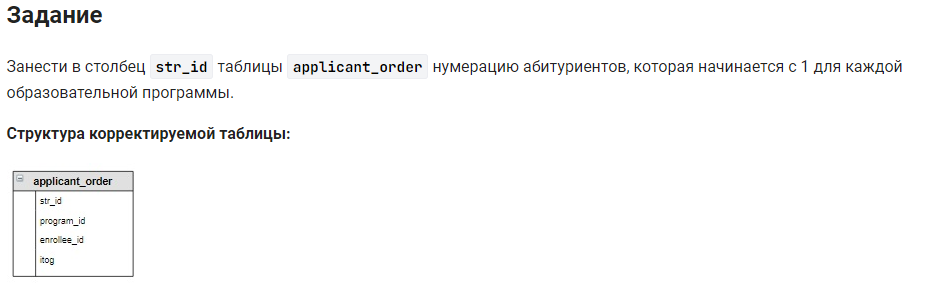
### PS. На этом шаге нумерацию реализуем с помощью переменных.  

~~~~MySQL
SET @prog_id = 0; 
SET @num_enr = 0;

UPDATE applicant_order 
   SET str_id = IF (program_id = @prog_id, @num_enr := @num_enr + 1, 
                            (@num_enr := 1 AND @prog_id := program_id) ); 
~~~~

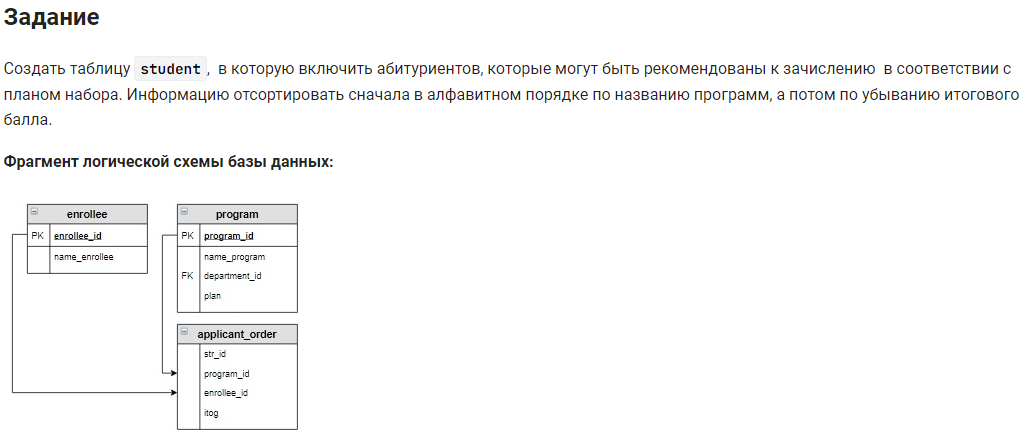

~~~~MySQL
CREATE TABLE student AS (
      SELECT program.name_program,
             enrollee.name_enrollee,
             a_o.itog
        FROM applicant_order AS a_o 
       RIGHT JOIN program ON program.program_id = a_o.program_id
                         AND program.plan >= a_o.str_id
       LEFT JOIN enrollee ON enrollee.enrollee_id = a_o.enrollee_id
       ORDER BY program.name_program,
                a_o.itog DESC);     
~~~~